In [2]:
dataset = 'load' # 'load' or 'generate'
retrain_models = False # False or True or 'save'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.FATAL)

import gpflow
import library.models.deep_vmgp as deep_vmgp
import library.models.vmgp as vmgp
from doubly_stochastic_dgp.dgp import DGP

import matplotlib as mpl
import matplotlib.pyplot as plt
import cplot

import sklearn.model_selection
import pickle
from pathlib import Path
from types import SimpleNamespace
from library.helper import TrainTestSplit, initial_inducing_points
from library import metrics

%matplotlib inline

In [4]:
random_seed = 19960111
def reset_seed():
    np.random.seed(random_seed)
    tf.random.set_random_seed(random_seed)

In [5]:
if dataset == 'generate':
    s = 0.4
    n = 500//2
    reset_seed()
    rng = np.random.default_rng(random_seed)
    m1, m2 = np.array([[-1,1],[2,1]])
    X1 = rng.multivariate_normal(m1,s*np.eye(2), size=n)
    X2 = rng.multivariate_normal(m2,s*np.eye(2), size=n)
    y1 = X1[:,0]**2 + X1[:,0]
    y2 = X2[:,1]**2 + X2[:,1]

    X = np.concatenate([X1,X2],axis=0)
    y = np.concatenate([y1,y2],axis=0)[:,None]

    X_all, y_all = X,y
    n = X_all.shape[0]
    kfold = sklearn.model_selection.KFold(2,shuffle=True,random_state=random_seed)
    folds = [
        [TrainTestSplit(X_all[train],X_all[test]), TrainTestSplit(y_all[train],y_all[test])]
        for train, test in kfold.split(X_all, y_all)
    ]
    X,y = folds[0]
elif dataset == 'load':
    with open('./dataset.pkl','rb') as f:
        X, y = pickle.load(f)
        X_all, y_all = np.concatenate(X,axis=0), np.concatenate(y,axis=0)

In [6]:
scalers = SimpleNamespace(x=sklearn.preprocessing.StandardScaler(),y=sklearn.preprocessing.StandardScaler())
scalers.x.fit(X.train)
X = X.apply(lambda x: scalers.x.transform(x))
scalers.y.fit(y.train)
y = y.apply(lambda y: scalers.y.transform(y))

In [37]:
models = pd.Series(index=pd.Index([],dtype='object'), dtype=object)
parameters = pd.Series({p.stem:p for p in Path('./optimized_parameters/').glob('*.pkl')}, dtype=object).map(read_parameters)

y_pred = pd.DataFrame(dtype=float, index=range(y.test.size), columns=pd.MultiIndex(levels=[[],['mean','var']],codes=[[],[]],names=['model','']))
results = pd.DataFrame(columns=['RMSE','NLPD','MRAE'],dtype=float)

In [8]:
def read_parameters(p):
    try:
        with p.open('rb') as f:
            return pickle.load(f)
    except:
        return None

def train_model(model_label):
    m = models[model_label]
    if retrain_models == True or retrain_models == 'save' or model_label not in parameters.index:
        print('Training',model_label)
        variance_parameter = m.likelihood.variance if not isinstance(m, DGP) else m.likelihood.likelihood.variance
        variance_parameter.assign(0.01)
        # First round
        variance_parameter.trainable  = False
        opt = gpflow.train.AdamOptimizer(0.01)
        opt.minimize(m, maxiter=2000)

        # Second round
        variance_parameter.trainable  = True
        opt = gpflow.train.AdamOptimizer(0.01)
        opt.minimize(m, maxiter=5000)
        if retrain_models == 'save' or model_label not in parameters.index:
            with open(f'./optimized_parameters/{model_label}.pkl','wb') as f:
                pickle.dump(m.read_trainables(), f)
    else:
        m.assign(parameters[model_label])

# Create, train, and predict with models

In [40]:
n,D = X.train.shape
m_v = 25
m_u, Q, = 50, D
Z_v = (m_v,D)
Z_u = (m_u,Q)
sample_size = 200

### SGPR

In [42]:
models['sgpr'] = gpflow.models.SGPR(X.train, y.train, gpflow.kernels.RBF(D, ARD=True), initial_inducing_points(X.train, m_u))
train_model('sgpr')
y_pred[('sgpr','mean')], y_pred[('sgpr','var')] = models['sgpr'].predict_y(X.test)

### Deep Mahalanobis GP

In [50]:
reset_seed()
with gpflow.defer_build():
    models['dvmgp'] = deep_vmgp.DeepVMGP(
        X.train, y.train, Z_u, Z_v,
        [gpflow.kernels.RBF(D,ARD=True) for i in range(Q)],
        full_qcov=False, diag_qmu=False
    )
models['dvmgp'].compile()
train_model('dvmgp')
y_pred[('dvmgp','mean')], y_pred[('dvmgp','var')] = models['dvmgp'].predict_y(X.test)

### Show scores

In [51]:
for m in models.index:
    scaled_y_test = scalers.y.inverse_transform(y.test)
    scaled_y_pred = [
        scalers.y.inverse_transform(y_pred[m].values[:,[0]]),
        scalers.y.var_ * y_pred[m].values[:,[1]]
    ]
    results.at[m,'MRAE'] = metrics.mean_relative_absolute_error(scaled_y_test, scaled_y_pred[0]).squeeze()
    results.at[m,'RMSE'] = metrics.root_mean_squared_error(scaled_y_test, scaled_y_pred[0]).squeeze()
    results.at[m,'NLPD'] = metrics.negative_log_predictive_density(scaled_y_test, *scaled_y_pred).squeeze()

results

,RMSE,NLPD,MRAE
sgpr,0.214817,0.040753,0.188357
dvmgp,0.128758,-1.883254,0.040366


# Plot results

In [55]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [7]:
f = plt.figure()
ax = plt.gca()
ax.scatter(scalers.x.transform(X_all)[:,0],scalers.x.transform(X_all)[:,1],edgecolors='white',facecolors='none')
lims = (ax.get_xlim(), ax.get_ylim())
plt.close(f)

In [56]:
n = 50
grid_points = np.dstack(np.meshgrid(np.linspace(*lims[0],n), np.linspace(*lims[1],n))).reshape(-1,2)
grid_y = np.empty((len(models.index),grid_points.shape[0]))
for i,m in enumerate(models.index):
    reset_seed()
    grid_pred = models[m].predict_y(grid_points, sample_size)[0]
    if len(grid_pred.shape) == 3:
        grid_y[i] = grid_pred.mean(axis=0)[:,0]
    else:
        grid_y[i] = grid_pred[:,0]

grid_points = grid_points.reshape(n,n,2)
grid_y = grid_y.reshape(-1,n,n)

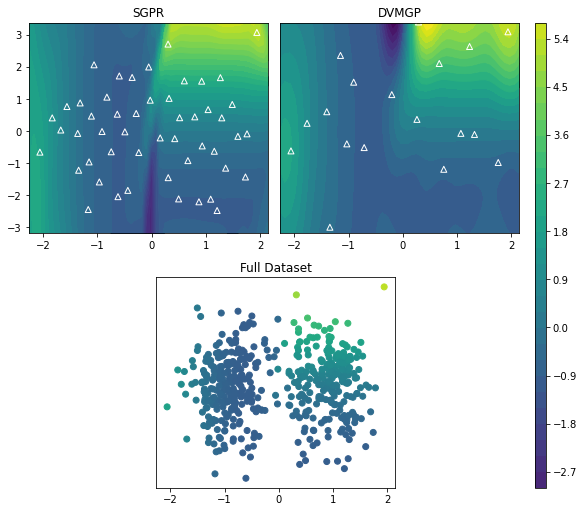

In [73]:
f = plt.figure(constrained_layout=True,figsize=(8,7))
gs = f.add_gridspec(ncols=4, nrows=2)
axs = np.empty(3,dtype=object)
axs[0] = f.add_subplot(gs[0,0:2])
axs[1] = f.add_subplot(gs[0,2:4],sharey=axs[0])
axs[2] = f.add_subplot(gs[1,1:3])

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

axs[0].set_title('SGPR')
axs[1].set_title('DVMGP')
axs[2].set_title('Full Dataset')

ims = np.empty((2,4),dtype=object)

for i,m in enumerate(['sgpr', 'dvmgp']):
    ax = axs[i]
    ims[0,i] = ax.contourf(grid_points[:,:,0],grid_points[:,:,1],grid_y[i],30)

    # Plot features
    Z = None
    if m == 'dgp':
        Z = models[m].layers[0].feature.Z.value
    elif m in ['sgpr','vmgp']:
        Z = models[m].feature.Z.value
    elif m == 'dvmgp':
        Z = models[m].Z_v.Z.value

    if Z is not None:
        ax.scatter(Z[:,0],Z[:,1],marker='^',edgecolors='white',facecolors='none')
#     ims[1,i] = ax.scatter(X.test[:,0],X.test[:,1],edgecolors='white',c=y.test)
    
ims[0,3] = axs[2].scatter(X.test[:,0],X.test[:,1],c=y.test)
ims[1,3] = axs[2].scatter(X.train[:,0],X.train[:,1],c=y.train)

for ax in axs:
    ax.set_xlim(lims[0]);
    ax.set_ylim(lims[1]);
    
clim = np.array([i.get_clim() for i in ims.flat if i is not None])
clim = (clim.min(), clim.max())
norm = mpl.colors.Normalize(vmin=clim[0], vmax=clim[1])
# norm = MidpointNormalize(vmin=clim[0], vmax=clim[1], midpoint=0)
for im in ims.flat:
    if im is not None:
        im.set_norm(norm)
f.colorbar(ims[0,0], ax=axs, orientation='vertical', fraction=1, aspect=50)

for im in ims[0,:3].flat:
    if im is not None:
        for c in im.collections:
            c.set_edgecolor("face")

f.savefig('./figs/outputs.pdf')

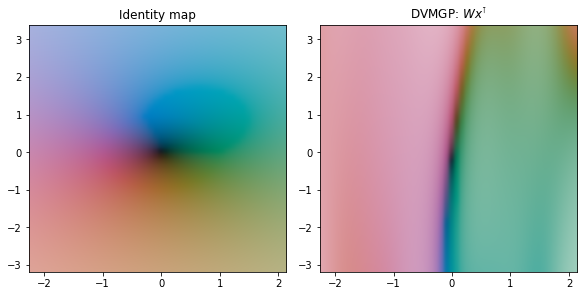

In [95]:
n = 50
grid_points = np.dstack(np.meshgrid(np.linspace(*lims[0],n), np.linspace(*lims[1],n))).reshape(-1,2)
grid_y = np.empty((grid_points.shape[0],2))

grid_y = models['dvmgp'].enquire_session().run(tf.matmul(
    tf.transpose(models['dvmgp'].compute_qW(grid_points)[0][...,0],[2,0,1]),grid_points[:,:,None]
)[:,:,0])

grid_points = grid_points.reshape(n,n,2)
grid_y = grid_y.reshape(n,n,2)

f = plt.figure(constrained_layout=True,figsize=(8,4))
gs = f.add_gridspec(ncols=2, nrows=1)
axs = np.empty(4,dtype=object)
axs[0] = f.add_subplot(gs[0,0])
axs[1] = f.add_subplot(gs[0,1])

extent = (*lims[0], *lims[1])
colorspace = 'cielab'
alpha = 0.7

axs[0].imshow(
    cplot.get_srgb1(grid_points[:,:,0] + grid_points[:,:,1]*1j, colorspace=colorspace, alpha=alpha),
    origin='lower',
    extent=extent,
    aspect='auto',
    interpolation='gaussian'
)
axs[0].set_title('Identity map')

axs[1].imshow(
    cplot.get_srgb1(grid_y[:,:,0] + grid_y[:,:,1]*1j, colorspace=colorspace, alpha=alpha),
    origin='lower',
    extent=extent,
    aspect='auto',
    interpolation='gaussian'
)
axs[1].set_title('DVMGP: $Wx^\intercal$');
f.savefig('./figs/layers.pdf')

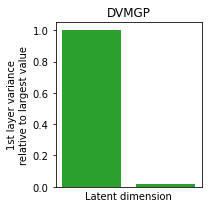

In [77]:
dvmgp_var = np.array([k.variance.value for k in models['dvmgp'].w_kerns])

f,ax = plt.subplots(1,1,figsize=(3,3))
ax.bar(np.arange(2), dvmgp_var/dvmgp_var.max(), color='C2')
ax.set_ylabel('1st layer variance\nrelative to largest value')

ax.set_xlabel('Latent dimension')
ax.set_xticks([])

ax.set_title('DVMGP')
f.tight_layout()
f.savefig('./figs/dims.pdf')